# NeurIPS conference  -  historical data analysis

Conferences often provide statistics for a particular year, presenting information such as acceptance rate, diversity, geographical and topic distribution, etc. Usually for only that year, or perhaps up to a few years back.

However, it might be useful to take a step back and see the big picture, in order to visualise some trends and gain useful insights.

## Data Sources

Here, the focus on the NeurIPS conference data. The accepted papers from all conference instances since 1987, when it was first held, are available on https://papers.nips.cc/. Unfortunately, there would be also many insights from rejected papers, but these are not available.

Thanks to the organisers of NeurIPS, all the accepted paper data is neatly organised onine, with the following information available:
- title
- year
- author names 
- suplementary material indicator (yes/no)
- [some] author affiliation
- [some] abstract
- [some] full paper text contents
- [some] reviews
- [TODO] number of citations (scraped from scholar)


In addition to this, I tried certain approaches  to extract more data which is not directly given on the main website. All the source code I used to obtain the data and generate the plots is on my GitHub.

## Preparing data

I first used the `scripts/neurips_download.py` to scrape all the data from the website. Then I extract and plot interesting data as shown below.

In [406]:
# # install packages if necessary
# ! pip install nltk
# ! pip install requests
# ! pip install beautifulsoup4
# ! pip install gender-guesser

In [407]:
import re
import nltk
import pickle
import requests
import collections
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12

from matplotlib.ticker import MaxNLocator
import gender_guesser.detector as gender
detector = gender.Detector()
import scipy.stats as stats
from bs4 import BeautifulSoup

In [408]:
with open('data/neurips_conf_data.pkl', 'rb') as handle:
    conf_data = pickle.load(handle)
    
total_authors = {}
total_institutions = {}
phd_authors = {}
year_stats = {}

year_stats['unique_authors_info'] = []
year_stats['unique_institutions_info'] = []

for kk, vals in conf_data.items():
    # Unique authors and institutions
    paper_info = {}
    author_papers = {}
    institution_papers = {}
    for paper in vals:
        # get yearly unique authors and papers per author
        for a_idx, a_name in enumerate(paper['authors']):
            ahash = '{} {}'.format(a_name['given_name'], a_name['family_name'])  # ahash = '{}_{}'.format(a_name['given_name'].upper(), a_name['family_name'].upper())
            if ahash in author_papers.keys():
                author_papers[ahash]['n_papers'].append((a_idx + 1, len(paper['authors'])))
            else:
                author_papers[ahash] = {}
                author_papers[ahash]['n_papers'] = [(a_idx + 1, len(paper['authors']))]
                author_papers[ahash]['gender'] = detector.get_gender(ahash.split()[0])
        # get yearly unique institutions and papers per institution
        for i_name in paper['institutions']:
            if i_name is None or i_name == '':
                continue
            if i_name in institution_papers.keys():
                institution_papers[i_name] += 1
            else:
                institution_papers[i_name] = 1
    # Update yearly author and institution info
    year_stats['unique_authors_info'].append(author_papers)
    year_stats['unique_institutions_info'].append(institution_papers)
    
    # Update total authors and institutions
    for t_author in author_papers.keys():
        if t_author in total_authors.keys():
            total_authors[t_author]['n_papers'].extend(author_papers[t_author]['n_papers'])
        else:
            total_authors[t_author] = {}
            total_authors[t_author]['n_papers'] = author_papers[t_author]['n_papers'].copy()
            total_authors[t_author]['gender'] = author_papers[t_author]['gender']
            
    for t_inst in institution_papers.keys():
        if t_inst in total_institutions.keys():
            total_institutions[t_inst] += institution_papers[t_inst]
        else:
            total_institutions[t_inst] = institution_papers[t_inst]
            
    # Update PhD author productivity
    for phd_auth in author_papers.keys():
        if phd_auth in phd_authors.keys():
            if int(kk) < phd_authors[phd_auth]['start_date'] + 5:
                phd_authors[phd_auth]['n_papers'].extend(author_papers[phd_auth]['n_papers'])
        else:
            phd_authors[phd_auth] = {}
            phd_authors[phd_auth]['start_date'] = int(kk)
            phd_authors[phd_auth]['n_papers'] = author_papers[phd_auth]['n_papers'].copy()
            phd_authors[phd_auth]['gender'] = author_papers[phd_auth]['gender']
    
    
# Sorting by number of papers
total_institutions_sorted = [{w: total_institutions[w]} for w in sorted(total_institutions, key=total_institutions.get, reverse=False) if w is not None and w != '']
total_authors_sorted = [{w: len(total_authors[w]['n_papers'])} for w in sorted(total_authors, key=lambda x: len(total_authors[x]['n_papers']), reverse=False)]


# PhD analysis
phd_start_year = {}
for kk, vv in phd_authors.items():
    if vv['start_date'] in phd_start_year.keys():
        phd_start_year[vv['start_date']].append(vv['n_papers'])
    else:
        phd_start_year[vv['start_date']] = [vv['n_papers']]
    

---

## Analysis

### Paper statistics

Let's first start with the total number of accepted papers. As the number of submissions is not available, we cannot monitor the acceptance rate. Still, the number of submissions drastically increased in the recent years:

In the first conference instance, in 1987, there was a total of 90 accepted papers, while in 2020 this number is 1898. The overall number of accepted papers over the years is 11578.

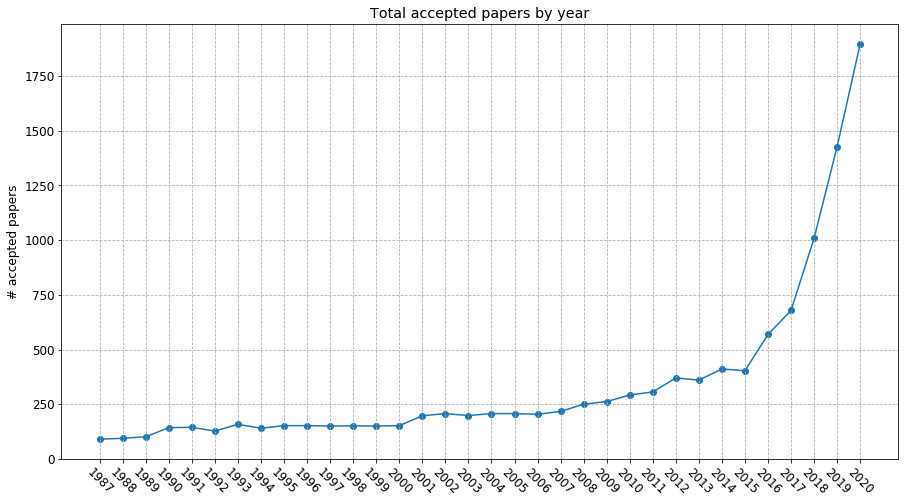

In [409]:
n_accepted = [len(conf_data[kk]) for kk in sorted(conf_data.keys())]
plt.scatter(np.arange(len(n_accepted)), n_accepted)
plt.plot(n_accepted)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Total accepted papers by year')
plt.ylabel('# accepted papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--')
# plt.savefig('plots/fig__total_accepted.png', dpi=300, bbox_inches='tight')
plt.show()

Further insights can be obtained from the paper title:
- Average title length
- Percentage of papers containing an abbreviation (if there is at least one all-caps word in the title)
- "... All you need" in the title

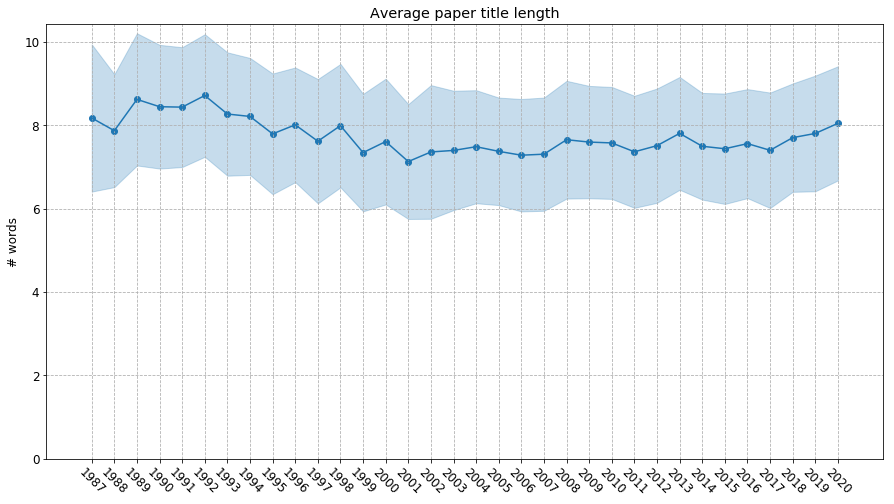

In [410]:
title_lenghts = np.array([np.mean([len(vv['title'].split(' ')) for vv in conf_data[kk]]) for kk in sorted(conf_data.keys())])
title_lenghts_std = np.array([np.std([len(vv['title'].split(' ')) for vv in conf_data[kk]]) for kk in sorted(conf_data.keys())])
plt.plot(title_lenghts, color='C0')
plt.fill_between(
    np.arange(len(conf_data)),
    title_lenghts - 0.5 * title_lenghts_std,
    title_lenghts + 0.5 * title_lenghts_std,
    alpha=0.25, color='C0')
plt.scatter(np.arange(len(title_lenghts)), title_lenghts, color='C0')
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average paper title length')
plt.ylabel('# words')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--')
# plt.savefig('plots/fig__title_length.png', dpi=300, bbox_inches='tight')
plt.show()

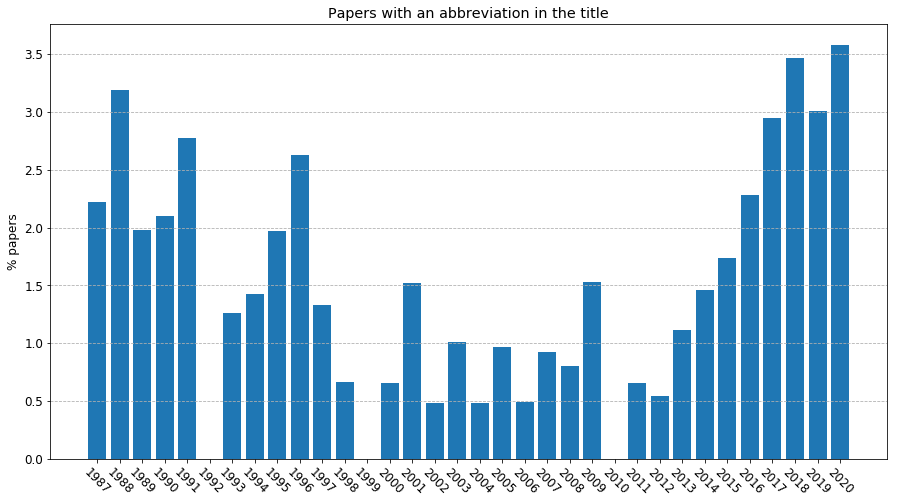

In [411]:
titles_abbreviations = [100 * np.mean([sum([ww.isupper() and ww[-1] == ':' for ww in vv['title'].split(' ')])
                                   for vv in conf_data[kk]])
                        for kk in sorted(conf_data.keys())]

plt.bar(np.arange(len(titles_abbreviations)), titles_abbreviations)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Papers with an abbreviation in the title')
plt.ylabel('% papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
# plt.savefig('plots/fig__title_abbreviations.png', dpi=300, bbox_inches='tight')
plt.show()

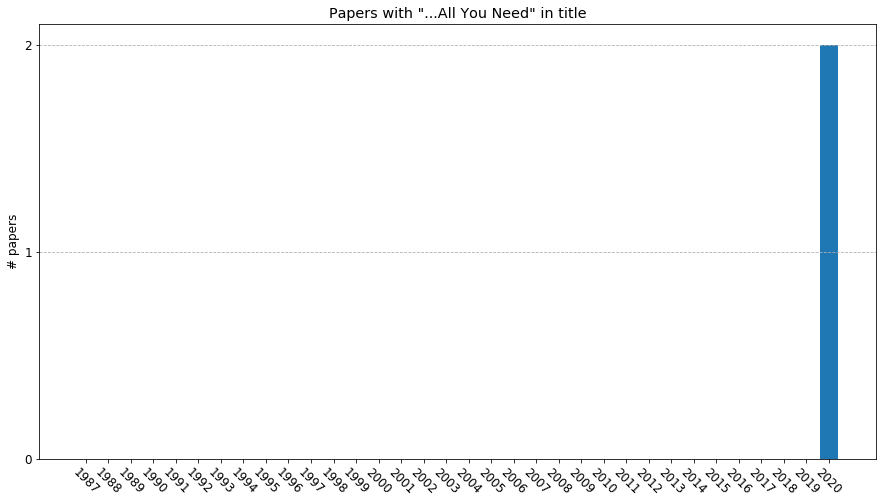

In [412]:
title_ayn = [sum([1 if 'All You Need' in vv['title'] or 'all you need' in vv['title'] else 0 for vv in conf_data[kk]]) for kk in sorted(conf_data.keys())]
plt.bar(np.arange(len(title_ayn)), title_ayn)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Papers with "...All You Need" in title')
plt.ylabel('# papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(linestyle='--', axis='y')
# plt.savefig('plots/fig__title_ayn.png', dpi=300, bbox_inches='tight')
plt.show()

Most common words and phrases in the title, that show up over the years

In [413]:
# Clean up titles
nltk.download('stopwords')
stop_words = list(set(nltk.corpus.stopwords.words('english'))) 
titles_no_stopwords = [[' '.join([ww.replace("\'",'') for ww in pp['title'].lower().split() if ww not in stop_words]) for pp in conf_data[kk]] for kk in sorted(conf_data.keys())]


[nltk_data] Downloading package stopwords to /home/robin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Normalising by the number of accepted paper, shows a different picture than not doing so.

In [414]:
n_accepted = np.array([len(conf_data[kk]) for kk in sorted(conf_data.keys())])
# n_accepted = np.ones(len(conf_data))

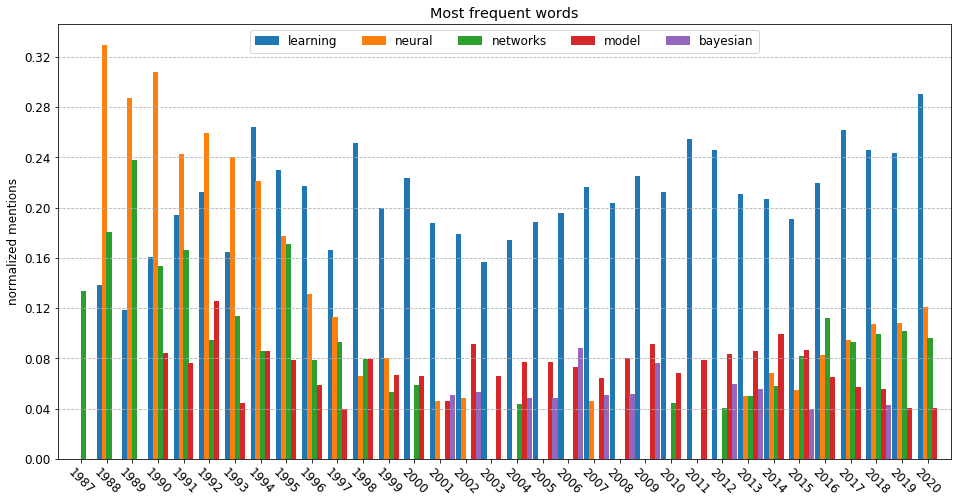

In [415]:
# Find most common single words
title_words_by_year = [[tt.split() for tt in yy] for yy in titles_no_stopwords]
title_words_by_year = [[y for x in oo for y in x] for oo in title_words_by_year]
common_words = [dict(collections.Counter(tt).most_common(10)) for tt in title_words_by_year]

# Extract most common 1gram phrase over the years
most_common_1grams = {}
for i, yy in enumerate(common_words):
    for kk in yy.keys():
        if kk in most_common_1grams.keys():
            most_common_1grams[kk][i] = yy[kk] / n_accepted[i]
        elif kk[-1] == 's' and kk[:-1] in most_common_1grams.keys():
            most_common_1grams[kk[:-1]][i] = yy[kk] / n_accepted[i]
        elif kk[-1] != 's' and kk+'s' in most_common_1grams.keys():
            most_common_1grams[kk+'s'][i] = yy[kk] / n_accepted[i]
        else:
            most_common_1grams[kk] = np.zeros(len(common_words))
# Cleanup
del most_common_1grams['via']
del most_common_1grams['using']
# Sort by number of mentions
sorted_1grams = collections.OrderedDict()
for k in sorted(most_common_1grams.keys(), key=lambda item: np.sum(most_common_1grams[item]), reverse=True):
    sorted_1grams[k] = most_common_1grams[k]

# Plot top N phrases
N = 5
OFFSET = 0.02
for i, (ph, fq) in enumerate(list(sorted_1grams.items())[:N]):
#     plt.plot(fq, label=ph, lw=5)
    plt.bar(np.arange(len(n_accepted)) + (i+1 - N/2)/(N+OFFSET*10), fq, width=1/(N+OFFSET), label=ph)
    
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.title('Most frequent words')
plt.ylabel('normalized mentions')
plt.ylim(0)
plt.xlim(-0.9, 33.9)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
# plt.grid(linestyle='--')
plt.grid(linestyle='--', axis='y')
lgd = plt.legend(ncol=N, loc='center', bbox_to_anchor=(0.5, 0.96, 0, 0))
# plt.savefig('plots/fig__title_1gram.png', dpi=300, bbox_inches='tight')
plt.show()  

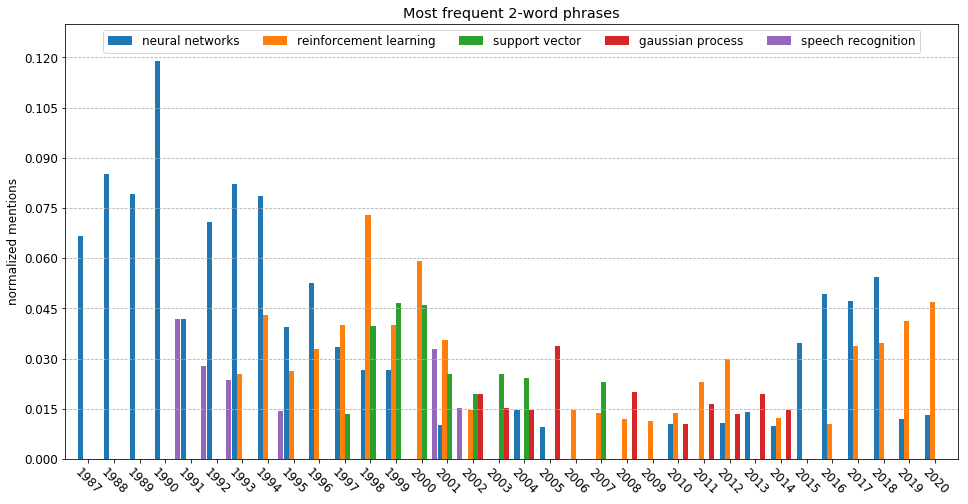

In [416]:
# Find most common 2-word phrases words
title_2grams_by_year = [[[' '.join(ww) for ww in nltk.ngrams(pp.split(), 2)] for pp in yy] for yy in titles_no_stopwords]
title_2grams_by_year = [[y for x in oo for y in x] for oo in title_2grams_by_year]
common_2grams = [dict(collections.Counter(tt).most_common(10)) for tt in title_2grams_by_year]

# Extract most common 2gram phrase over the years
most_common_2grams = {}
for i, yy in enumerate(common_2grams):
    for kk in yy.keys():
        if kk in most_common_2grams.keys():
            most_common_2grams[kk][i] = yy[kk] / n_accepted[i]
        elif kk[-1] == 's' and kk[:-1] in most_common_2grams.keys():
            most_common_2grams[kk[:-1]][i] = yy[kk] / n_accepted[i]
        elif kk[-1] != 's' and kk+'s' in most_common_2grams.keys():
            most_common_2grams[kk+'s'][i] = yy[kk] / n_accepted[i]
        else:
            most_common_2grams[kk] = np.zeros(len(common_2grams))
# Sort by number of mentions
sorted_2grams = collections.OrderedDict()
for k in sorted(most_common_2grams.keys(), key=lambda item: np.sum(most_common_2grams[item]), reverse=True):
    sorted_2grams[k] = most_common_2grams[k]
    
# Plot top N phrases
N = 5
OFFSET = 0.02
for i, (ph, fq) in enumerate(list(sorted_2grams.items())[:N]):
#     plt.plot(fq, label=ph, lw=3)
    plt.bar(np.arange(len(n_accepted)) + (i+1 - N/2)/(N+OFFSET * 10), fq, width=1/(N+OFFSET), label=ph)
    
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.title('Most frequent 2-word phrases')
plt.ylabel('normalized mentions')
plt.ylim(0, .13)
plt.xlim(-0.9, 33.9)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
# plt.grid(linestyle='--')
plt.grid(linestyle='--', axis='y')
lgd = plt.legend(ncol=N, loc='center', bbox_to_anchor=(0.5, 0.96, 0, 0))
# plt.savefig('plots/fig__title_2gram.png', dpi=300, bbox_inches='tight')
plt.show()
    

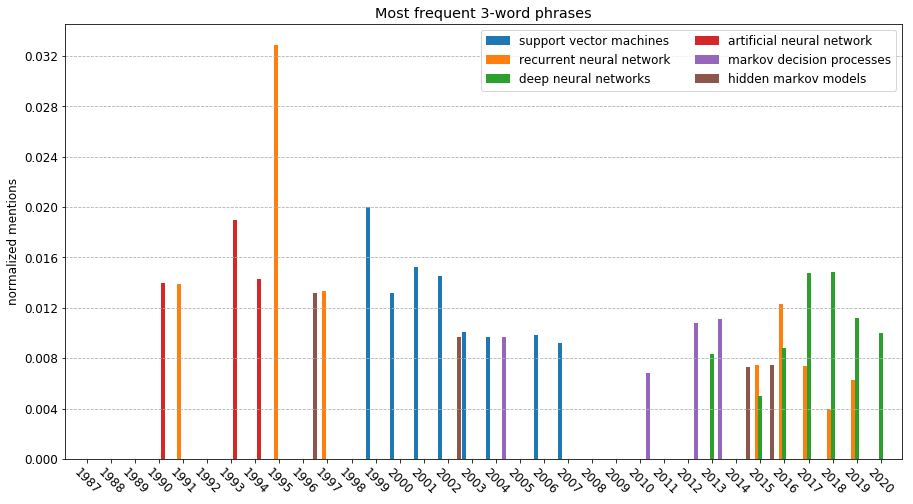

In [417]:
# Find most common 3-word phrases words
title_3grams_by_year = [[[' '.join(ww) for ww in nltk.ngrams(pp.split(), 3)] for pp in yy] for yy in titles_no_stopwords]
title_3grams_by_year = [[y for x in oo for y in x] for oo in title_3grams_by_year]
common_3grams = [dict(collections.Counter(tt).most_common(10)) for tt in title_3grams_by_year]

# Extract most common 3gram phrase over the years
most_common_3grams = {}
for i, yy in enumerate(common_3grams):
    for kk in yy.keys():
        if kk in most_common_3grams.keys():
            most_common_3grams[kk][i] = yy[kk] / n_accepted[i]
        elif kk[-1] == 's' and kk[:-1] in most_common_3grams.keys():
            most_common_3grams[kk[:-1]][i] = yy[kk] / n_accepted[i]
        elif kk[-1] != 's' and kk+'s' in most_common_3grams.keys():
            most_common_3grams[kk+'s'][i] = yy[kk] / n_accepted[i]
        else:
            most_common_3grams[kk] = np.zeros(len(common_3grams))
# Sort by number of mentions
sorted_3grams = collections.OrderedDict()
for k in sorted(most_common_3grams.keys(), key=lambda item: np.sum(most_common_3grams[item]), reverse=True):
    sorted_3grams[k] = most_common_3grams[k]
    
# Plot top N phrases
N = 6
OFFSET = 0.02
for i, (ph, fq) in enumerate(list(sorted_3grams.items())[:N]):
#     plt.plot(fq, label=ph, lw=3)
    plt.bar(np.arange(len(n_accepted)) + (i+1 - N/2)/(N+OFFSET*10), fq, width=1/(N+OFFSET), label=ph)

fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Most frequent 3-word phrases')
plt.ylabel('normalized mentions')
plt.ylim(0)
plt.xlim(-0.9, 33.9)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
# plt.grid(linestyle='--')
plt.grid(linestyle='--', axis='y')
lgd = plt.legend(ncol=N//3, loc='upper right', bbox_to_anchor=(1, 1, 0, 0))
# plt.savefig('plots/fig__title_3gram.png', dpi=300, bbox_inches='tight')
plt.show()

Further, some insights from the paper abstract:
- Average abstract length
- Average abstract word length
- Average abstract word complexity

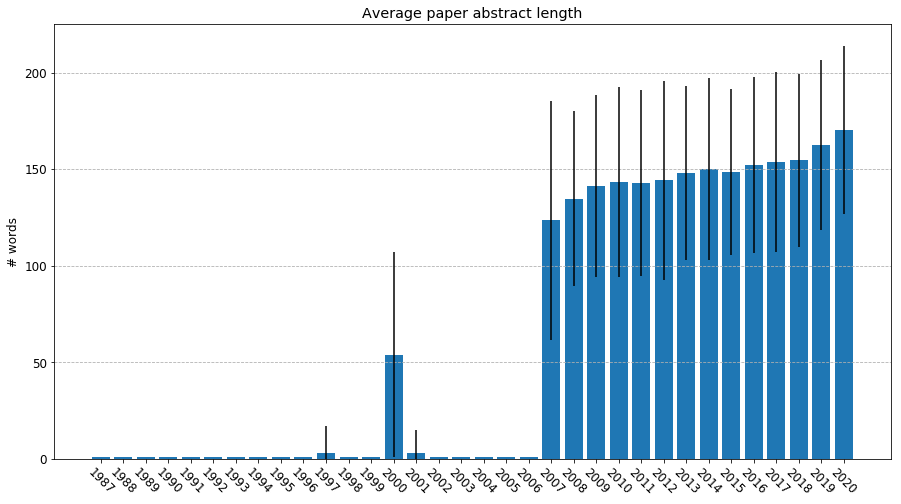

In [418]:
abstract_lenghts = np.array([np.mean([len(vv['abstract'].split(' ')) for vv in conf_data[kk] if vv['abstract'] is not None]) for kk in sorted(conf_data.keys())])
abstract_lenghts_std = np.array([np.std([len(vv['abstract'].split(' ')) for vv in conf_data[kk] if vv['abstract'] is not None]) for kk in sorted(conf_data.keys())])
plt.bar(np.arange(len(abstract_lenghts)), abstract_lenghts, yerr=abstract_lenghts_std)

#plt.plot(abstract_lenghts)
# plt.fill_between(
#     np.arange(len(conf_data)),
#     abstract_lenghts - 0.5 * abstract_lenghts_std,
#     abstract_lenghts + 0.5 * abstract_lenghts_std,
#     alpha=0.25)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average paper abstract length')
plt.ylabel('# words')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
# plt.savefig('plots/fig__abstract_length.png', dpi=300, bbox_inches='tight')
plt.show()

/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


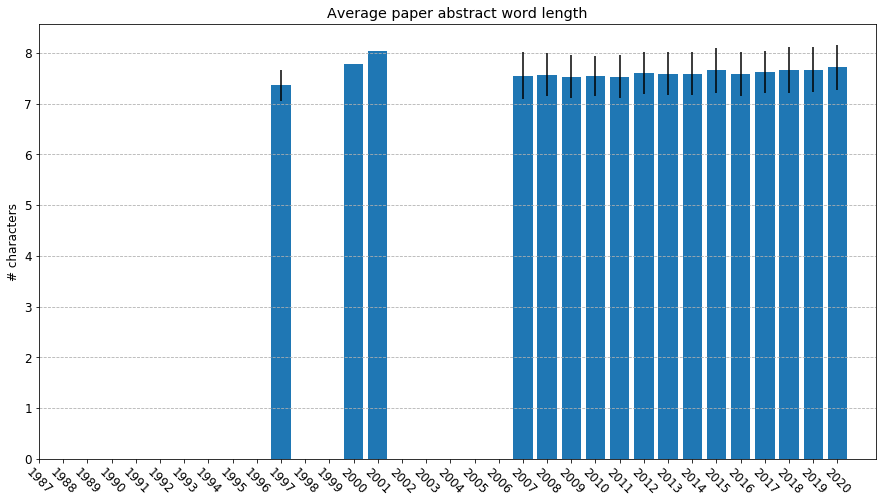

In [419]:
abstract_word_len = np.array([np.mean([np.mean([len(ww) for ww in vv['abstract'].replace('\n', ' ').split(' ') if len(ww) > 3]) for vv in conf_data[kk] if vv['abstract'] is not None and vv['abstract'] != '']) for kk in sorted(conf_data.keys())])
abstract_word_len_std = np.array([np.std([np.mean([len(ww) for ww in vv['abstract'].replace('\n', ' ').split(' ') if len(ww) > 3]) for vv in conf_data[kk] if vv['abstract'] is not None and vv['abstract'] != '']) for kk in sorted(conf_data.keys())])

plt.bar(np.arange(len(abstract_word_len)), abstract_word_len, yerr=abstract_word_len_std)
# plt.plot(abstract_word_len)
# plt.fill_between(
#     np.arange(len(conf_data)),
#     abstract_word_len - 0.5 * abstract_word_len_std,
#     abstract_word_len + 0.5 * abstract_word_len_std,
#     alpha=0.25)

fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average paper abstract word length')
plt.ylabel('# characters')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
# plt.savefig('plots/fig__abstract_words.png', dpi=300, bbox_inches='tight')
plt.show()

Indicators of papers containing supplemental material:
- Total number of papers containing some type of supplementary material (pdf or zip)
- Average number of papers containing some type of supplementary material (pdf or zip)

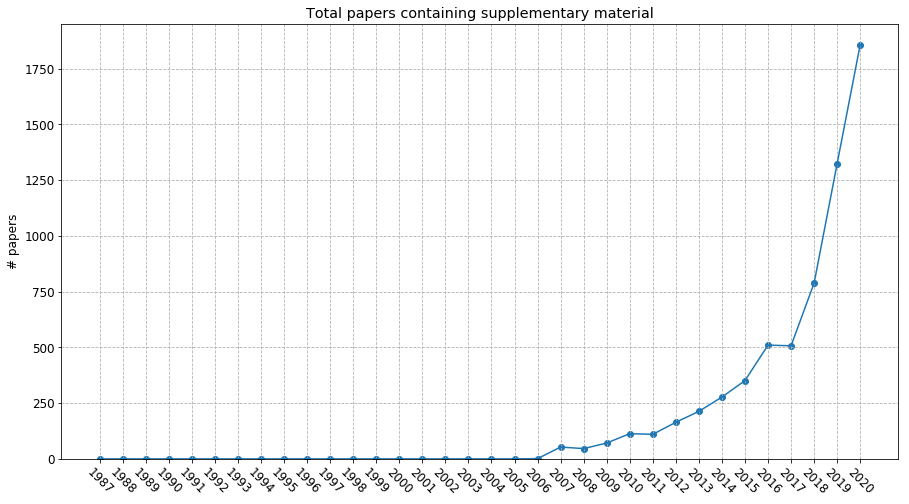

In [420]:
total_supplemental = [np.sum([vv['has_supplement'] for vv in conf_data[kk]]) for kk in sorted(conf_data.keys())]
plt.scatter(np.arange(len(total_supplemental)), total_supplemental)
plt.plot(total_supplemental)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Total papers containing supplementary material')
plt.ylabel('# papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--')
# plt.savefig('plots/fig__supplemental_total.png', dpi=300, bbox_inches='tight')
plt.show()

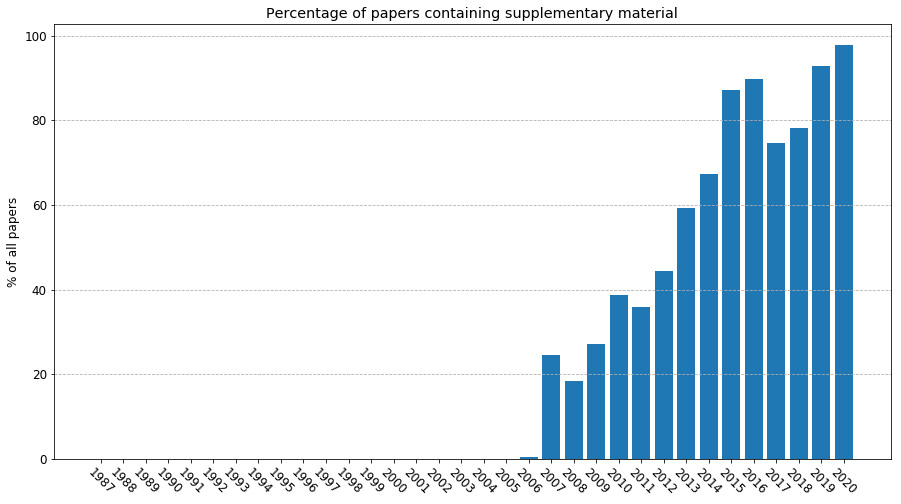

In [421]:
percent_supplemental = [np.mean([vv['has_supplement'] for vv in conf_data[kk]]) * 100 for kk in sorted(conf_data.keys())]
# plt.plot(percent_supplemental)
plt.bar(np.arange(len(percent_supplemental)), percent_supplemental)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Percentage of papers containing supplementary material')
plt.ylabel('% of all papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
# plt.savefig('plots/fig__supplemental_percent.png', dpi=300, bbox_inches='tight')
plt.show()

---

### Author statistics

Regarding author information, quick disclaimer, there are some inconsistencies in the names as they are sometimes abbreviated e.g. "J.", "Josh" or "Joshua". Although it is difficult to fix all such instances manually due to the large number of authors, we still have a good enough estimate.

In the first year there were 166 authors participating, while in the last conference 5917 authors, leading to an overall total of 17670 participants over 34 conference instances.

The total number of individuals participating each year are shown below, and it closely follows the number of accepted papers:

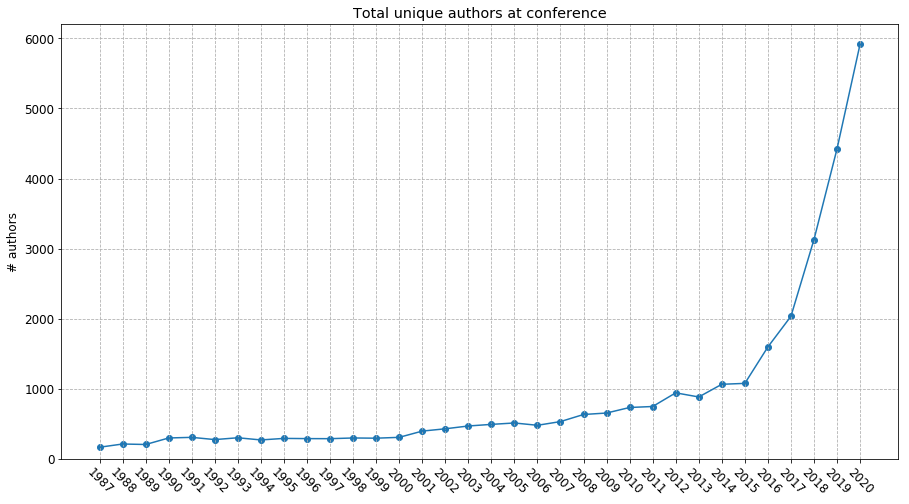

In [422]:
unique_authors = [len(ss) for ss in year_stats['unique_authors_info']]
plt.scatter(np.arange(len(unique_authors)), unique_authors)
plt.plot(unique_authors)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Total unique authors at conference')
plt.ylabel('# authors')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--')
# plt.savefig('plots/fig__unique_authors.png', dpi=300, bbox_inches='tight')
plt.show()

It might also be interesting to look at the actual world population and compare against this:

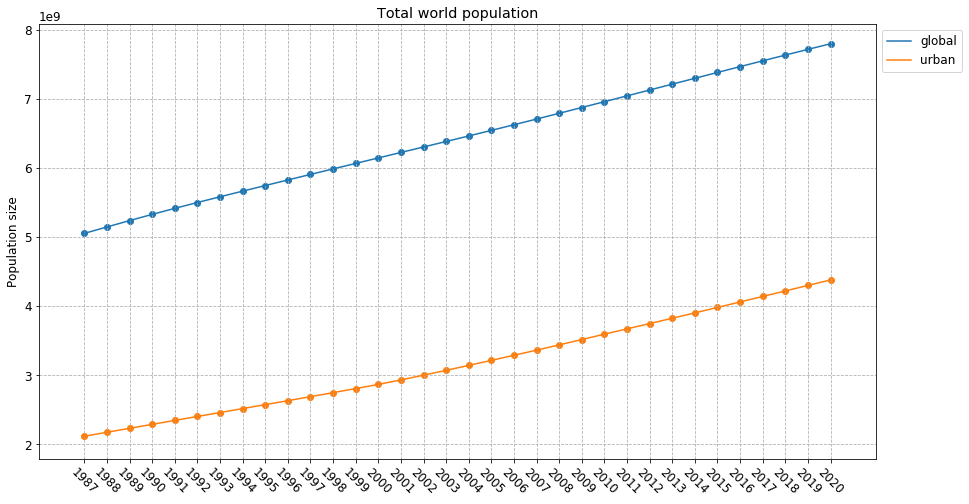

In [423]:
with open('data/world_population.pkl', 'rb') as handle:
    world_population = pickle.load(handle)
    
pop_global = np.array([world_population[int(yy)]['pop_global'] for yy in sorted(conf_data.keys())])
pop_urban = np.array([world_population[int(yy)]['pop_urban'] for yy in sorted(conf_data.keys())])
# world
plt.scatter(np.arange(len(pop_global)), pop_global)
plt.plot(pop_global, label='global')
# urban
plt.scatter(np.arange(len(pop_urban)), pop_urban)
plt.plot(pop_urban, label='urban')
    
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Total world population')
plt.ylabel('Population size')
# plt.ylim(0, 0.00015)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--')
lgd = plt.legend(ncol=1, loc='upper left', bbox_to_anchor=(1, 0., 1, 1))
# plt.savefig('plots/fig__world_population.png', dpi=300, bbox_inches='tight', bbox_extra_artists=(lgd,))
plt.show()

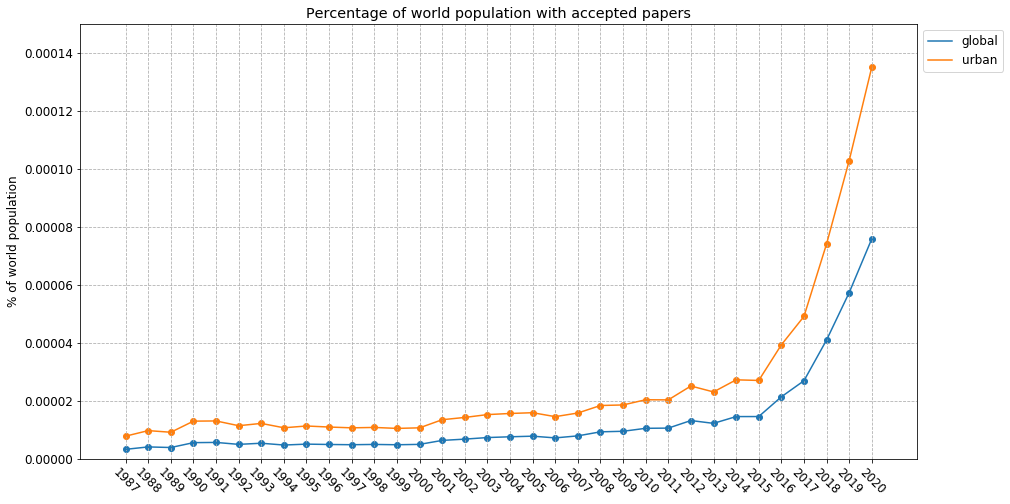

In [424]:
with open('data/world_population.pkl', 'rb') as handle:
    world_population = pickle.load(handle)

unique_authors = np.array([len(ss) for ss in year_stats['unique_authors_info']])
pop_global = np.array([world_population[int(yy)]['pop_global'] for yy in sorted(conf_data.keys())])
pop_urban = np.array([world_population[int(yy)]['pop_urban'] for yy in sorted(conf_data.keys())])
# world
authors_global = 100 * unique_authors / pop_global
plt.scatter(np.arange(len(authors_global)), authors_global)
plt.plot(authors_global, label='global')
# urban
authors_urban = 100 * unique_authors / pop_urban
plt.scatter(np.arange(len(authors_urban)), authors_urban)
plt.plot(authors_urban, label='urban')

fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Percentage of world population with accepted papers')
plt.ylabel('% of world population')
plt.ylim(0, 0.00015)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--')
lgd = plt.legend(ncol=1, loc='upper left', bbox_to_anchor=(1, 0., 1, 1))
# plt.savefig('plots/fig__world_precent.png', dpi=300, bbox_inches='tight', bbox_extra_artists=(lgd,))
plt.show()

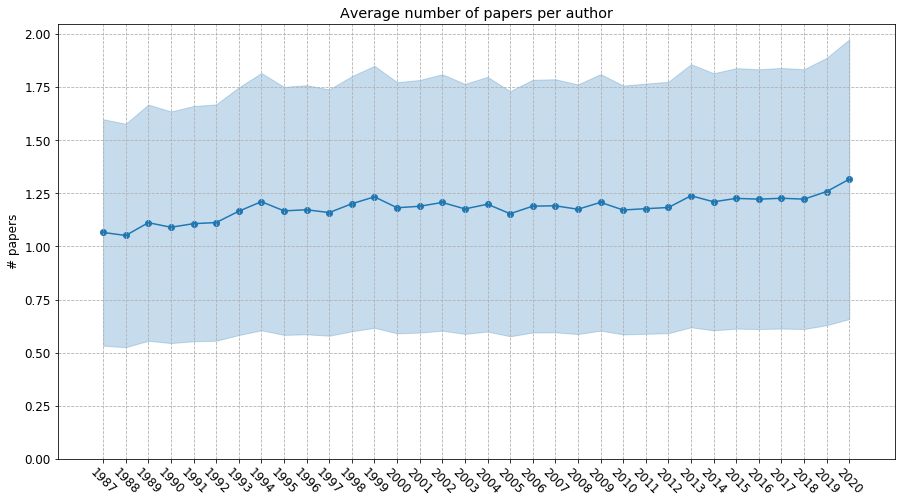

In [425]:
papers_per_author_mean = np.array([np.mean([len(vv['n_papers']) for vv in ss.values()]) for ss in year_stats['unique_authors_info']])
papers_per_author_std = np.array([np.mean([len(vv['n_papers']) for vv in ss.values()]) for ss in year_stats['unique_authors_info']])
plt.plot(papers_per_author_mean, color='C0')
plt.fill_between(
    np.arange(len(conf_data)),
    papers_per_author_mean - 0.5 * papers_per_author_std,
    papers_per_author_mean + 0.5 * papers_per_author_std,
    alpha=0.25, color='C0')
plt.scatter(np.arange(len(papers_per_author_mean)), papers_per_author_mean, color='C0')

fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average number of papers per author')
plt.ylabel('# papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--')
# plt.savefig('plots/fig__papers_per_author.png', dpi=300, bbox_inches='tight')
plt.show()

The top 50 publishing authors, with most accepted papers:

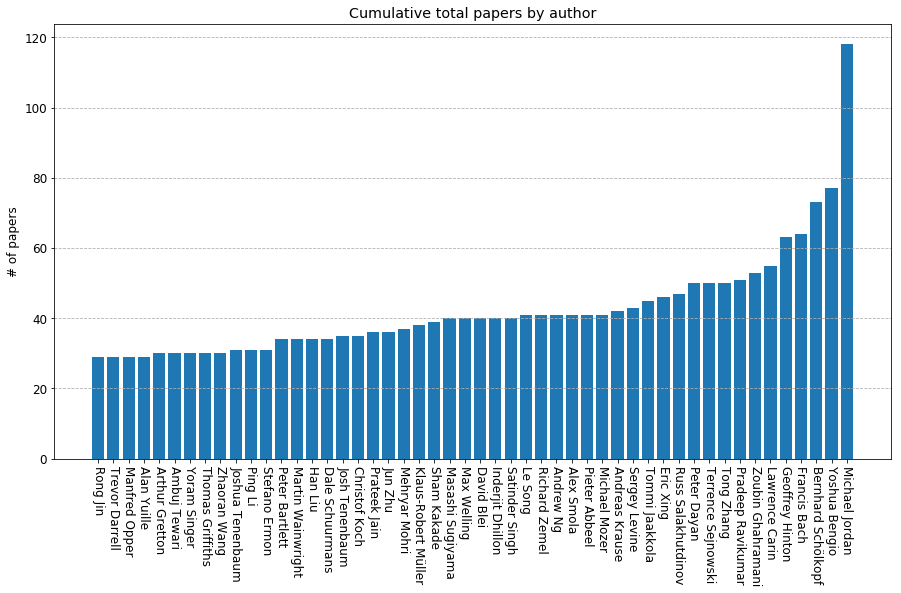

In [426]:
n_papers = [list(vv.values())[0] for vv in total_authors_sorted][-50:]
n_authors = [list(vv.keys())[0] for vv in total_authors_sorted][-50:]

plt.bar(np.arange(len(n_papers)), n_papers)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Cumulative total papers by author')
plt.ylabel('# of papers')
plt.ylim(0)
plt.xticks(np.arange(len(n_authors)), n_authors, rotation=-90)
plt.grid(linestyle='--', axis='y')
# plt.savefig('plots/fig__all_authors.png', dpi=300, bbox_inches='tight')
plt.show()

To investigate the actual inequality of the distribution of papers per author, one can estimate the Gini coefficient. The blue part in the graph below shows the cumulative number of publications, once we sort the authors by their number of publications. If each author had the same number of publications, the blue area would cover the orange area as well (which is the ideal equal distribution). Therefore, the ratio: (orange area) / (orange + blue area) gives us the Gini coefficient. The value of 0 indicates total equality (no orange area), while 1 indicates total inequality (all papers are published by a single author).

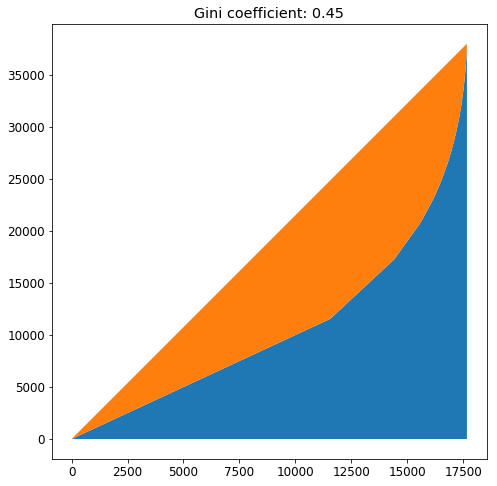

In [427]:
gg = [list(vv.values())[0] for vv in total_authors_sorted]
share_real = np.cumsum(gg)
share_ideal = np.cumsum(np.ones_like(share_real) * share_real[-1] / len(share_real))
share_diff = np.sum(share_ideal - share_real)
gini_coef = share_diff / np.sum(share_ideal)
plt.fill_between(np.arange(len(total_authors_sorted)), 0, share_real)
plt.fill_between(np.arange(len(total_authors_sorted)), share_real, share_ideal)
# plt.axis('')
plt.title("Gini coefficient: {}".format(gini_coef.round(2)))
plt.gca().set_aspect(1/(share_ideal[-1]/len(share_ideal)), adjustable='box')
fig = plt.gcf()
fig.set_size_inches(8, 8)
# plt.savefig('plots/fig__all_authors__gini.png', dpi=300, bbox_inches='tight')
plt.show()

Although author diversity is an important aspect, information such as author gender diversity is not available from the NeurIPS paper website. It is possible to get a very rough estimate using a python library, which is based on comparing the author's given name to a name database (however mostly "western" names). The "unknown" label is mostly assigned to non-western names, or cases where the author's given name is abbreviated.

Below are the graphs showing proportion of all papers and last-author papers, published by each author group. The last author is usually a more senior academic, such as a group leader or a supervisor.

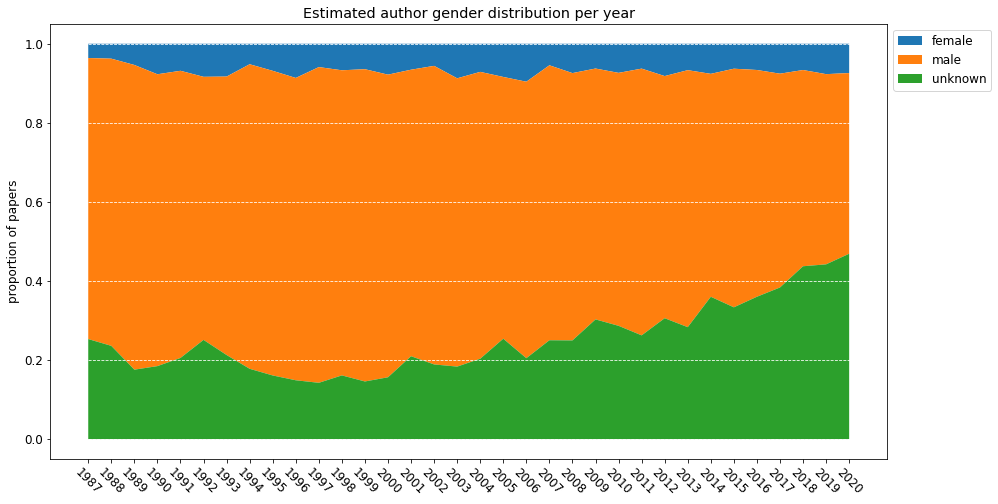

In [428]:
n_authors = np.array([len(ss) for ss in year_stats['unique_authors_info']])
n_female = np.array([np.sum(['female' in vv['gender'] for vv in ss.values()]) for ss in year_stats['unique_authors_info']])
n_female = n_female / n_authors
n_male = np.array([np.sum([vv['gender'] == 'male' or vv['gender'] == 'mostly_male' for vv in ss.values()]) for ss in year_stats['unique_authors_info']])
n_male = n_male / n_authors
n_unknown = np.array([np.sum(['male' not in vv['gender'] for vv in ss.values()]) for ss in year_stats['unique_authors_info']])
n_unknown = n_unknown / n_authors

n_years = np.arange(len(year_stats['unique_authors_info']))
plt.fill_between(n_years, n_unknown + n_male, n_unknown + n_male + n_female, label='female')
plt.fill_between(n_years, n_unknown, n_unknown + n_male, label='male')
plt.fill_between(n_years, 0, n_unknown, label='unknown')

fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Estimated author gender distribution per year')
plt.ylabel('proportion of papers')
plt.ylim(-0.05)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
lgd = plt.legend(ncol=1, loc='upper left', bbox_to_anchor=(1, 0., 1, 1))
plt.grid(linestyle='--', color='w', axis='y')
# plt.savefig('plots/fig__genders_total.png', dpi=300, bbox_inches='tight', bbox_extra_artists=(lgd,))
plt.show()

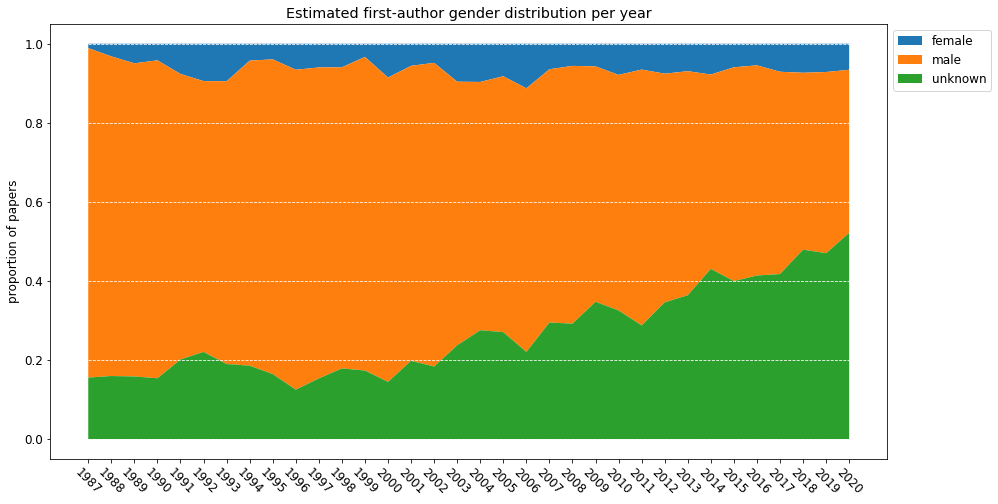

In [429]:
# same as n_accepted
n_accepted = np.array([np.sum([np.sum([pp[0] == 1 for pp in vv['n_papers']]) for vv in ss.values()]) for ss in year_stats['unique_authors_info']])

n_first_female = np.array([np.sum([np.sum([pp[0] == 1 for pp in vv['n_papers']]) for vv in ss.values() if 'female' in vv['gender']]) for ss in year_stats['unique_authors_info']])
n_first_female = n_first_female / n_accepted

n_first_male = np.array([np.sum([np.sum([pp[0] == 1 for pp in vv['n_papers']]) for vv in ss.values() if (vv['gender'] == 'male' or vv['gender'] == 'mostly_male')]) for ss in year_stats['unique_authors_info']])
n_first_male = n_first_male / n_accepted

n_first_unknown = np.array([np.sum([np.sum([pp[0] == 1 for pp in vv['n_papers']]) for vv in ss.values() if 'male' not in vv['gender']]) for ss in year_stats['unique_authors_info']])
n_first_unknown = n_first_unknown / n_accepted

n_years = np.arange(len(year_stats['unique_authors_info']))
plt.fill_between(n_years, n_first_unknown + n_first_male, n_first_unknown + n_first_male + n_first_female, label='female')
plt.fill_between(n_years, n_first_unknown, n_first_unknown + n_first_male, label='male')
plt.fill_between(n_years, 0, n_first_unknown, label='unknown')

fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Estimated first-author gender distribution per year')
plt.ylabel('proportion of papers')
plt.ylim(-0.05)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
lgd = plt.legend(ncol=1, loc='upper left', bbox_to_anchor=(1, 0., 1, 1))
plt.grid(linestyle='--', color='w', axis='y')
# plt.savefig('plots/fig__genders_first.png', dpi=300, bbox_inches='tight', bbox_extra_artists=(lgd,))
plt.show()

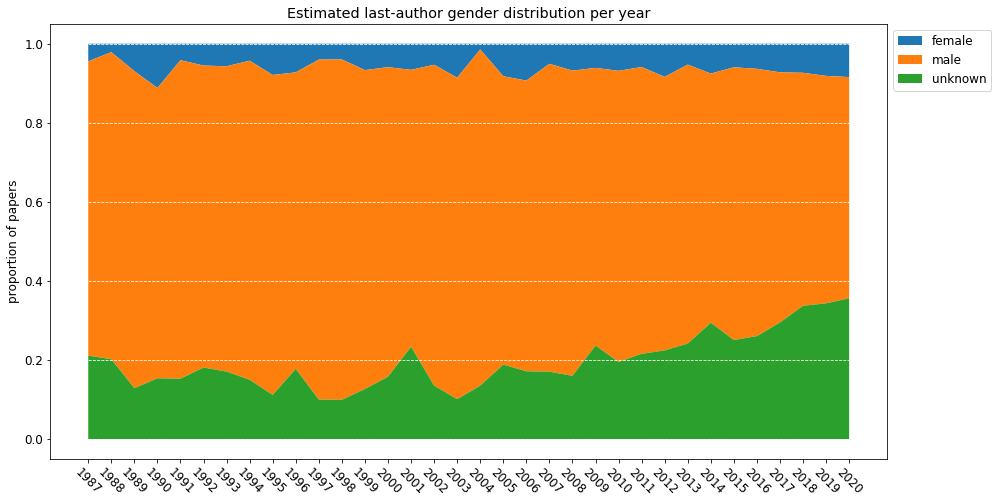

In [430]:
# same as n_accepted
n_accepted = np.array([np.sum([np.sum([pp[0] == pp[1] for pp in vv['n_papers']]) for vv in ss.values()]) for ss in year_stats['unique_authors_info']])

n_first_female = np.array([np.sum([np.sum([pp[0] == pp[1] for pp in vv['n_papers']]) for vv in ss.values() if 'female' in vv['gender']]) for ss in year_stats['unique_authors_info']])
n_first_female = n_first_female / n_accepted

n_first_male = np.array([np.sum([np.sum([pp[0] == pp[1] for pp in vv['n_papers']]) for vv in ss.values() if (vv['gender'] == 'male' or vv['gender'] == 'mostly_male')]) for ss in year_stats['unique_authors_info']])
n_first_male = n_first_male / n_accepted

n_first_unknown = np.array([np.sum([np.sum([pp[0] == pp[1] for pp in vv['n_papers']]) for vv in ss.values() if 'male' not in vv['gender']]) for ss in year_stats['unique_authors_info']])
n_first_unknown = n_first_unknown / n_accepted

n_years = np.arange(len(year_stats['unique_authors_info']))
plt.fill_between(n_years, n_first_unknown + n_first_male, n_first_unknown + n_first_male + n_first_female, label='female')
plt.fill_between(n_years, n_first_unknown, n_first_unknown + n_first_male, label='male')
plt.fill_between(n_years, 0, n_first_unknown, label='unknown')

fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Estimated last-author gender distribution per year')
plt.ylabel('proportion of papers')
plt.ylim(-0.05)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
lgd = plt.legend(ncol=1, loc='upper left', bbox_to_anchor=(1, 0., 1, 1))
plt.grid(linestyle='--', color='w', axis='y')
# plt.savefig('plots/fig__genders_last.png', dpi=300, bbox_inches='tight', bbox_extra_artists=(lgd,))
plt.show()

## "PhD" author statistics

Next, I was interested in estimating the number of publications by PhD students over the years. Even though there is no way to reliably estimate the number of PhD students, and which authors are PhD students, what we can do is to check how many papers were published by each author, within the first 5 years since their first publication at this conference.

Both the total amount of papers and first-author papers are mostly constant, with the trend going upwards, which could be expected.

The graphs below show:
- average number of papers published within author's first 5 years.
- average number of __first author__ papers published within author's first 5 years, excluding single-author papers (not considering equal contributions, as there is no such information. If one autor had N first-author papers in one year, this author's estimated gender is counted N times.)
- average number of __last author__ papers published within author's first 5 years (probably not their first time publishing)


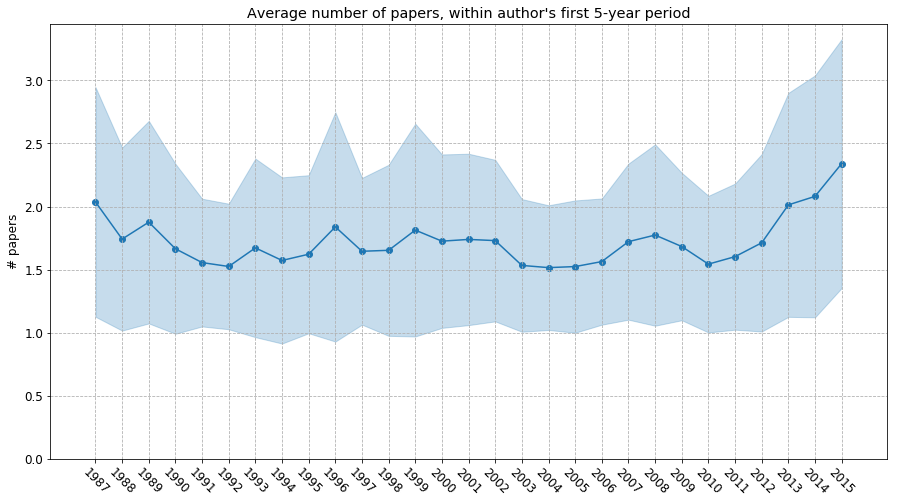

In [431]:
phd_productivity = np.array([np.mean([len(aa) for aa in yy]) for yy in phd_start_year.values()])[:-5]
phd_productivity_std = np.array([np.std([len(aa) for aa in yy]) for yy in phd_start_year.values()])[:-5]
plt.plot(phd_productivity, color='C0')
plt.fill_between(
    np.arange(len(phd_productivity)),
    phd_productivity - 0.5 * phd_productivity_std,
    phd_productivity + 0.5 * phd_productivity_std,
    alpha=0.25, color='C0')
plt.scatter(np.arange(len(phd_productivity)), phd_productivity, color='C0')
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title("Average number of papers, within author's first 5-year period")
plt.ylabel('# papers')
plt.ylim(0)
plt.xticks(np.arange(len(phd_start_year) - 5), list(phd_start_year.keys())[:-5], rotation=-45)
plt.grid(linestyle='--')
# plt.savefig('plots/fig__phd_all.png', dpi=300, bbox_inches='tight')
plt.show()

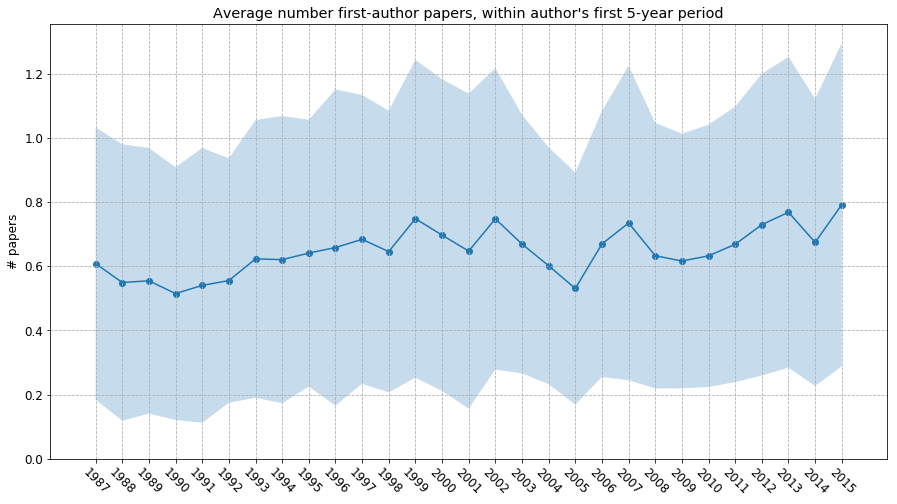

In [432]:
phd_first_author = np.array([np.mean([sum([pp[1] > 1 and pp[0] == 1 for pp in aa]) for aa in yy]) for yy in phd_start_year.values()])[:-5]
phd_first_author_std = np.array([np.std([sum([pp[1] > 1 and pp[0] == 1 for pp in aa]) for aa in yy]) for yy in phd_start_year.values()])[:-5]
plt.plot(phd_first_author)
plt.fill_between(
    np.arange(len(phd_first_author)),
    phd_first_author - 0.5 * phd_first_author_std,
    phd_first_author + 0.5 * phd_first_author_std,
    alpha=0.25)
plt.scatter(np.arange(len(phd_first_author)), phd_first_author, color='C0')
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title("Average number first-author papers, within author's first 5-year period")
plt.ylabel('# papers')
plt.ylim(0)
plt.xticks(np.arange(len(phd_start_year) - 5), list(phd_start_year.keys())[:-5], rotation=-45)
plt.grid(linestyle='--')
# plt.savefig('plots/fig__phd_first.png', dpi=300, bbox_inches='tight')
plt.show()

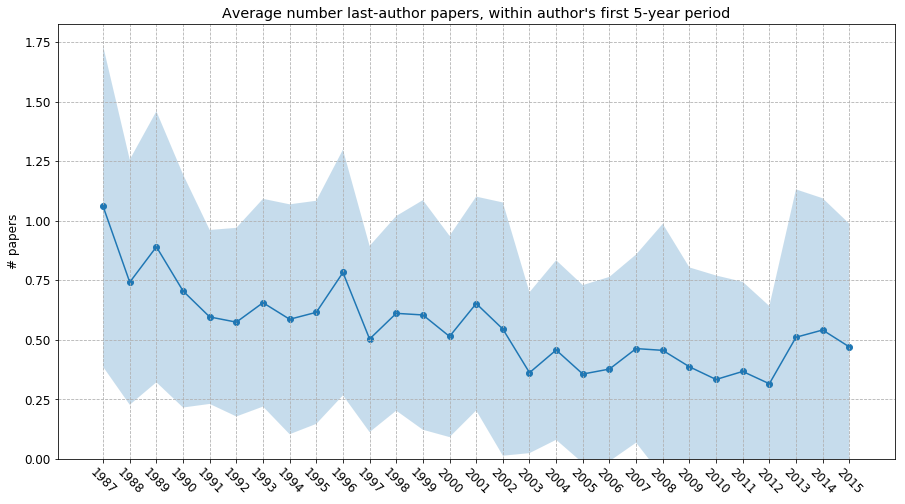

In [433]:
phd_last_author = np.array([np.mean([sum([pp[0] == pp[1]  for pp in aa]) for aa in yy]) for yy in phd_start_year.values()])[:-5]
phd_last_author_std = np.array([np.std([sum([pp[0] == pp[1]  for pp in aa]) for aa in yy]) for yy in phd_start_year.values()])[:-5]

plt.plot(phd_last_author)
plt.fill_between(
    np.arange(len(phd_last_author)),
    phd_last_author - 0.5 * phd_last_author_std,
    phd_last_author + 0.5 * phd_last_author_std,
    alpha=0.25)
plt.scatter(np.arange(len(phd_last_author)), phd_last_author, color='C0')
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title("Average number last-author papers, within author's first 5-year period")
plt.ylabel('# papers')
plt.ylim(0)
plt.xticks(np.arange(len(phd_start_year) - 5), list(phd_start_year.keys())[:-5], rotation=-45)
plt.grid(linestyle='--')
# plt.savefig('plots/fig__phd_last.png', dpi=300, bbox_inches='tight')
plt.show()

### Institution statistics

More interesting insights come from the authors' institution affiliations, and their participation over the years. Since the first conference there was a total of 2672 participating institutions.

Disclaimer:
- Affiliation information was not available before 2013
- The actual institution names are sometimes inconsistent (e.g. "Harvard Unviersity" (small typo), "Harvard University", "Harvard College", "Harvard", "Harvard Medical School", "Harvard/MIT", etc) and this might lead to some inaccuracies in the final results. However, even though that these examples are counted as separate institutions, we can still get good estimates.

In [434]:
# example
[dd for dd in total_institutions.keys() if 'Harvard' in dd]

['Harvard Unviersity',
 'Harvard',
 'Harvard Medical School',
 'Harvard University/Mila',
 'Harvard University, MIT CSAIL',
 'Google Research / Harvard',
 'Harvard/MIT',
 'Harvard and Twitter',
 'Chalmers / Harvard / Lille / Oslo',
 'Harvard University & MIT',
 'Harvard University',
 'Harvard University and Twitter',
 'Brown, MGH, VA, Harvard',
 'Harvard College',
 'Hebrew University and Harvard University',
 'Harvard University & University of Washington',
 'Harvard and Center for Brains, Minds, and Machines']

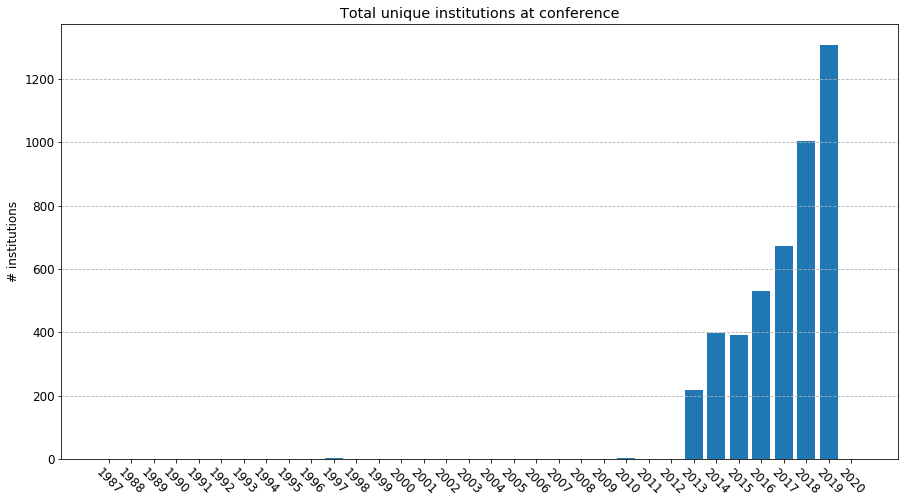

In [435]:
unique_institutions = [len(ss) for ss in year_stats['unique_institutions_info']]
plt.bar(np.arange(len(unique_institutions)), unique_institutions)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Total unique institutions at conference')
plt.ylabel('# institutions')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
# plt.savefig('plots/fig__unique_institutions.png', dpi=300, bbox_inches='tight')
plt.show()

/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


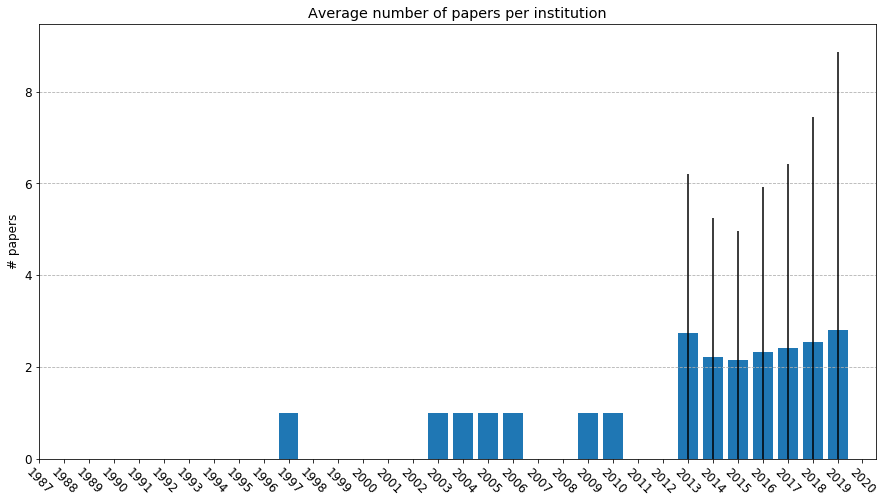

In [436]:
papers_per_institution = [np.mean([vv for vv in ss.values()]) for ss in year_stats['unique_institutions_info']]
papers_per_institution_std = [np.std([vv for vv in ss.values()]) for ss in year_stats['unique_institutions_info']]
plt.bar(np.arange(len(papers_per_institution)), papers_per_institution, yerr=papers_per_institution_std)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average number of papers per institution')
plt.ylabel('# papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
# plt.savefig('plots/fig__papers_per_institution.png', dpi=300, bbox_inches='tight')
plt.show()

The top 50 publishing institutions with the highest number of papers:

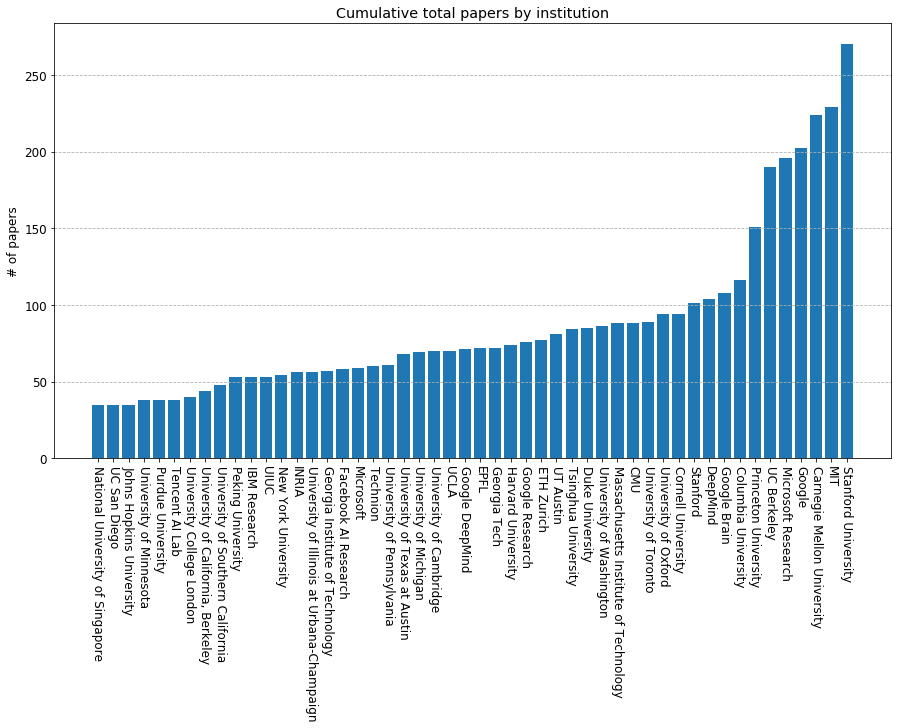

In [437]:
n_papers = [list(vv.values())[0] for vv in total_institutions_sorted][-50:]
n_institutions = [list(vv.keys())[0] for vv in total_institutions_sorted][-50:]

plt.bar(np.arange(len(n_papers)), n_papers)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Cumulative total papers by institution')
plt.ylabel('# of papers')
plt.ylim(0)
plt.xticks(np.arange(len(n_institutions)), n_institutions, rotation=-90)
plt.grid(linestyle='--', axis='y')
# plt.savefig('plots/fig__all_institutions.png', dpi=300, bbox_inches='tight')
plt.show()

Similarly as before, the estimated Gini coefficient below shows the inequality of the distribution of papers per institution. In this case, the coefficient of 0.68 indicates a much higher inequality than with individual authors.

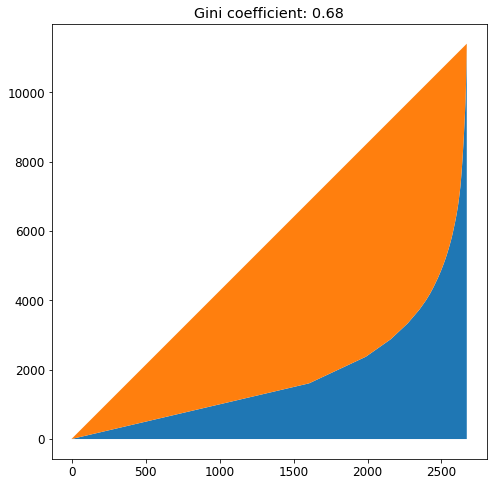

In [438]:
gg = [list(vv.values())[0] for vv in total_institutions_sorted]
share_real = np.cumsum(gg)
share_ideal = np.cumsum(np.ones_like(share_real) * share_real[-1] / len(share_real))
share_diff = np.sum(share_ideal - share_real)
gini_coef = share_diff / np.sum(share_ideal)
plt.fill_between(np.arange(len(total_institutions_sorted)), 0, share_real)
plt.fill_between(np.arange(len(total_institutions_sorted)), share_real, share_ideal)
plt.title("Gini coefficient: {}".format(gini_coef.round(2)))
plt.gca().set_aspect(1/(share_ideal[-1]/len(share_ideal)), adjustable='box')
fig = plt.gcf()
fig.set_size_inches(8, 8)
# plt.savefig('plots/fig__all_institutions__gini.png', dpi=300, bbox_inches='tight')
plt.show()
# http://kimberlyfessel.com/mathematics/applications/gini-use-cases/
# 

---

### Collaboration statistics

A proxy for an indicator of collaboration, can be obtained via the average number of authors per paper. This number has been steadily increasing, which could indicate more complex research projects published, more openness to collaboration, etc.

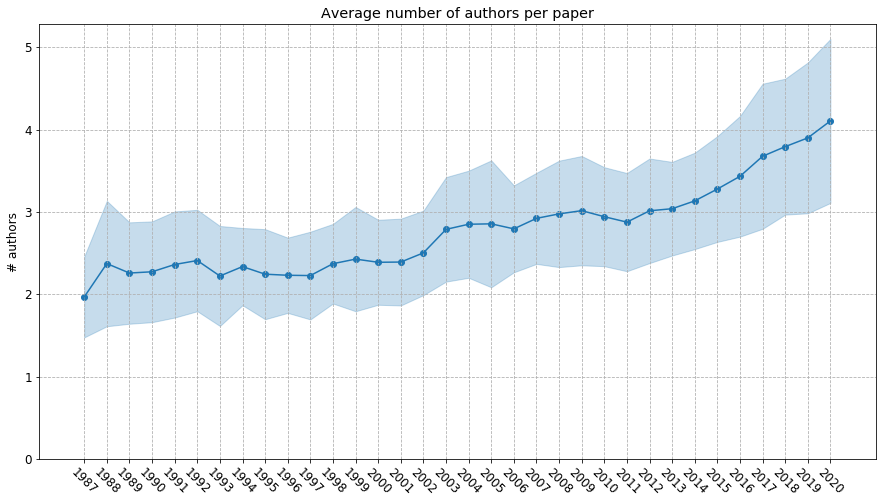

In [439]:
authors_per_paper_mean = np.array([np.mean([len(pp['authors']) for pp in conf_data[kk]]) for kk in sorted(conf_data.keys())])
authors_per_paper_std = np.array([np.std([len(pp['authors']) for pp in conf_data[kk]]) for kk in sorted(conf_data.keys())])
plt.plot(authors_per_paper_mean, color='C0')
plt.fill_between(
    np.arange(len(conf_data)),
    authors_per_paper_mean - 0.5 * authors_per_paper_std,
    authors_per_paper_mean + 0.5 * authors_per_paper_std,
    alpha=0.25, color='C0')
plt.scatter(np.arange(len(authors_per_paper_mean)), authors_per_paper_mean, color='C0')
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average number of authors per paper')
plt.ylabel('# authors')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--')
# plt.savefig('plots/fig__authors_per_paper.png', dpi=300, bbox_inches='tight')
plt.show()

Regarding only  single author papers, this trend has significantly gone down:

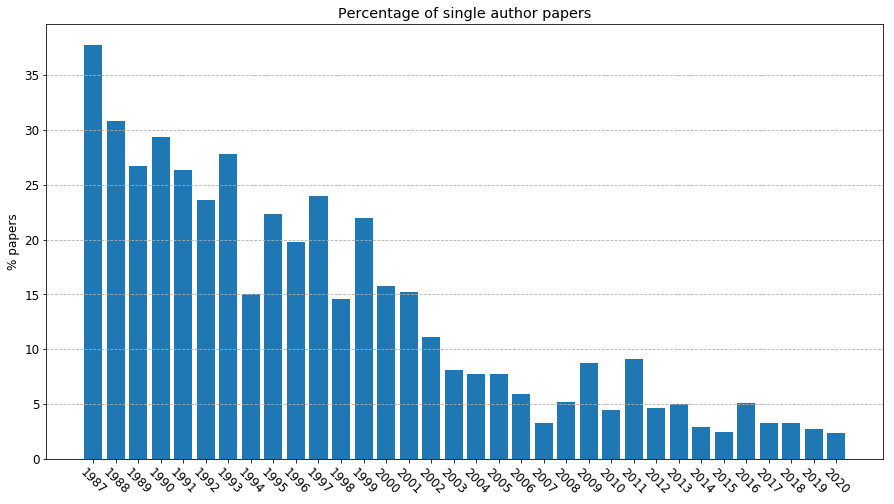

In [440]:
single_authors = 100 * np.array([np.mean([len(pp['authors'])==1 for pp in conf_data[kk]]) for kk in sorted(conf_data.keys())])
plt.bar(np.arange(len(single_authors)), single_authors)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Percentage of single author papers')
plt.ylabel('% papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
# plt.savefig('plots/fig__single_author.png', dpi=300, bbox_inches='tight')
plt.show()

While the number of institutions per paper has not significantly changed:(variance is shown as vertical black lines)

/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


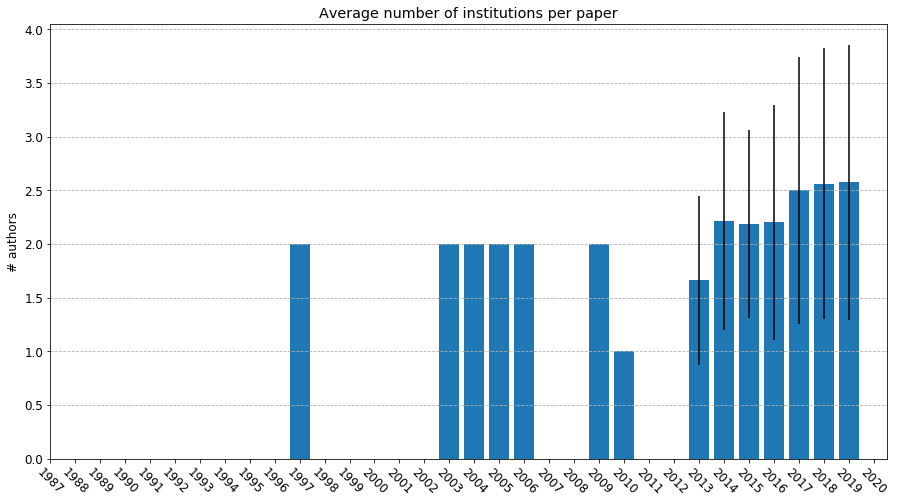

In [441]:
institutions_per_paper = [np.mean([len(pp['institutions']) for pp in conf_data[kk] if len(pp['institutions']) and pp['institutions'][0] is not None and pp['institutions'][0] != '']) for kk in sorted(conf_data.keys())]
institutions_per_paper_std = [np.std([len(pp['institutions']) for pp in conf_data[kk] if len(pp['institutions']) and pp['institutions'][0] is not None and pp['institutions'][0] != '']) for kk in sorted(conf_data.keys())]

plt.bar(np.arange(len(institutions_per_paper)), institutions_per_paper, yerr=institutions_per_paper_std)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average number of institutions per paper')
plt.ylabel('# authors')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
# plt.savefig('plots/fig__institutions_per_paper.png', dpi=300, bbox_inches='tight')
plt.show()

### Funding statistics

Another interesting observation is the relationship between the GDP of the institution's country w.r.t. the number of accepted papers. The country information is not included in the paper metadata, so it needs to be inferred based on the institution name, by scraping wikipedia. Regarding GDP info, I downloaded the spreadsheet file from https://databank.worldbank.org/data/download/GDP.xls and parsed the data for the exctracted countries for 2019.

It would be interesting to understand how the GDP of a country relates to the available research funding, and subsequently if there is a correlation with the number of accepted papers.

We can see a correlation in both standard and log-plots, with the US being a clear front runner. If we assume that the wealth is connected with the available research funding, which could explain such correlation ...

we can see a slight positive correlation between the country's GDP and the paper output its institutions produced. To quantify the correlation, I calculated the Pearson's correlation coefficient $\rho = 0.83$ with the significance $p=4.75\times10^{-10}$. 

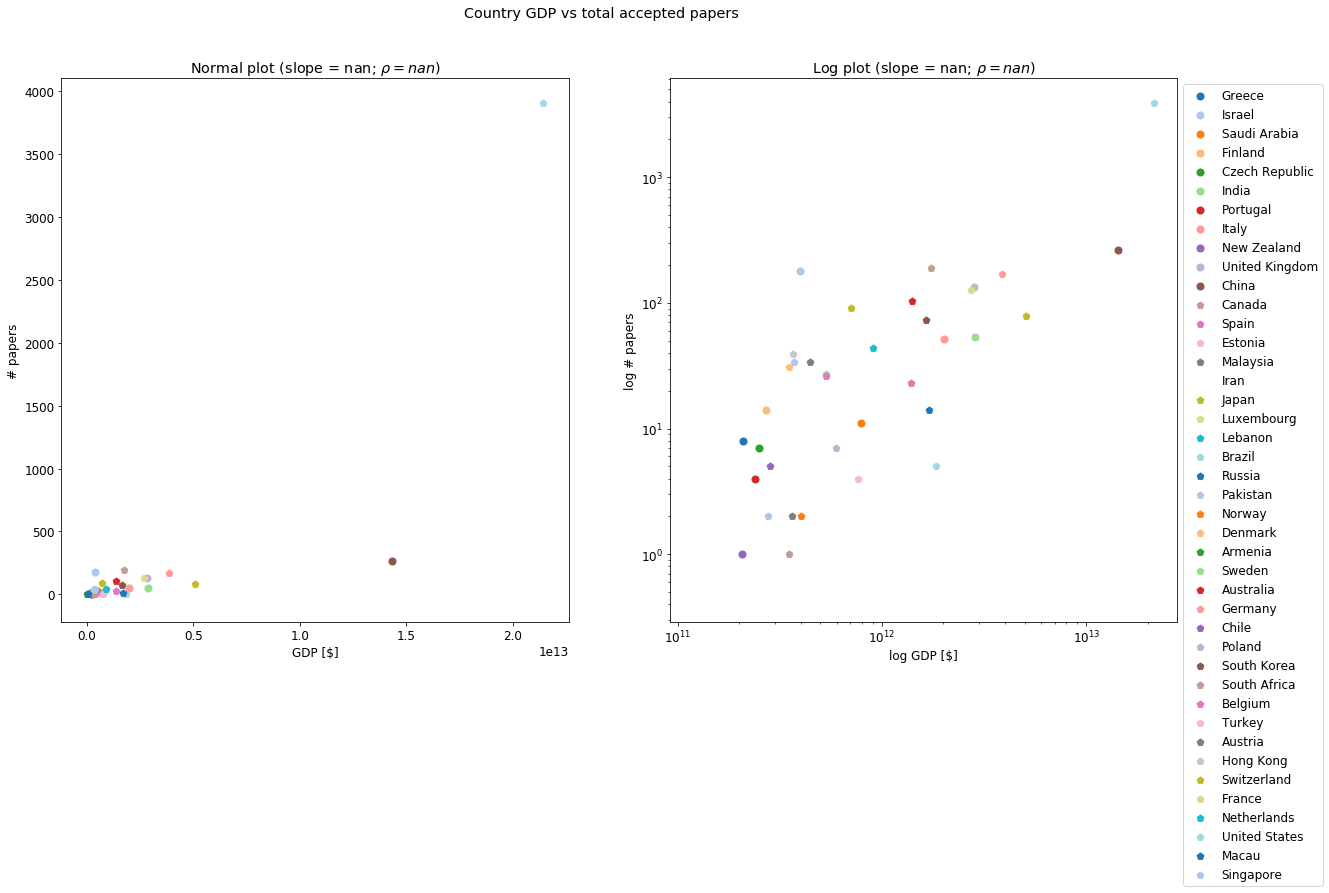

In [442]:
with open('data/country_papers.pkl', 'rb') as handle:
    country_papers = pickle.load(handle)
with open('data/country_gdp.pkl', 'rb') as handle:
    country_gdp = pickle.load(handle)
    
data_gdp = []
data_paper = []

# Plot datapoints
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)
NUM_COLORS = len(country_papers)
cm = plt.get_cmap('tab20')
ax[0].set_prop_cycle('color', [cm(i % 20) for i in range(NUM_COLORS)])
ax[1].set_prop_cycle('color', [cm(i % 20) for i in range(NUM_COLORS)])
for i, c_names in enumerate(country_papers.keys()):
    if c_names in country_gdp.keys():
        data_gdp.append(country_gdp[c_names])
        data_paper.append(country_papers[c_names])
        ax[0].scatter(country_gdp[c_names], country_papers[c_names], s=50, label=c_names, marker='o' if i<20 else 'p')
        ax[1].scatter(country_gdp[c_names], country_papers[c_names], s=50, label=c_names, marker='o' if i<20 else 'p')

# Calculate the pearson's correlation coefficient
corr, pval = stats.pearsonr(data_gdp, data_paper)
logcorr, logpval = stats.pearsonr(np.log(data_gdp), np.log(data_paper))

# Fit a line
x = np.linspace(min(data_gdp), max(data_gdp), 100)
res = stats.linregress(data_gdp, data_paper)
ax[0].plot(x, res.intercept + res.slope * x, 'k--', color="0.5")

logres = stats.linregress(np.log(data_gdp), np.log(data_paper))
ax[1].plot(x, np.exp(logres.intercept + logres.slope * np.log(x)), 'k--', color="0.5")

# Plot
fig.suptitle('Country GDP vs total accepted papers')
ax[0].set_title(r'Normal plot (slope = {:.2e}; $\rho = {}$)'.format(res.slope, corr.round(2)))
ax[0].set_xlabel('GDP [$]')
ax[0].set_ylabel('# papers')
ax[1].set_title(r'Log plot (slope = {}; $\rho = {}$)'.format(logres.slope.round(2), logcorr.round(2)))
ax[1].set_xlabel('log GDP [$]')
ax[1].set_ylabel('log # papers')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
lgd = ax[1].legend(ncol=1, loc='upper left', bbox_to_anchor=(1, 0., 1, 1))
# plt.savefig('plots/fig__country_vs_gdp.png', dpi=300, bbox_inches='tight', bbox_extra_artists=(lgd,))
plt.show()

---

## [TODO]

### Citation statistics

- Average number of citations per paper (although this is biased as older papers have been around more)

/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


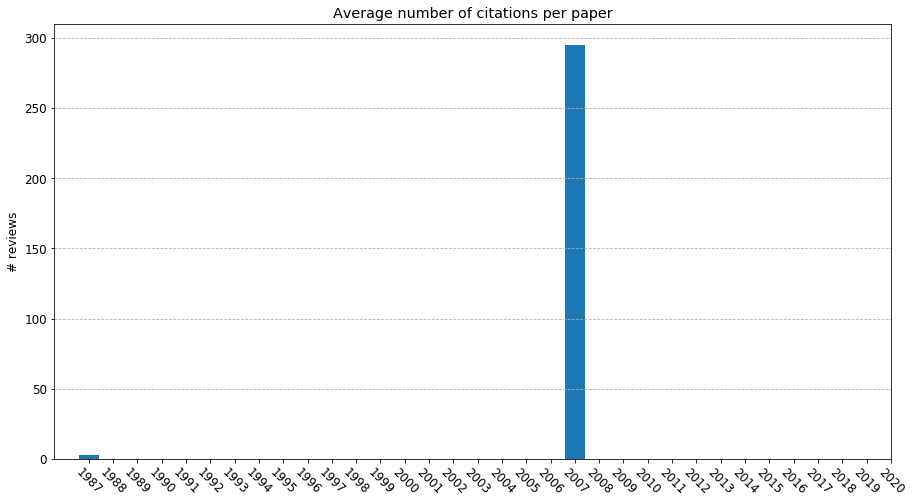

In [443]:
n_citations = [np.mean([vv['citations'] for vv in vals if vv['citations'] is not None]) for vals in conf_data.values()]
n_citations_std = [np.std([vv['citations'] for vv in vals if vv['citations'] is not None]) for vals in conf_data.values()]
plt.bar(np.arange(len(n_citations)), n_citations)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average number of citations per paper')
plt.ylabel('# reviews')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
# plt.savefig('plots/fig__citations_per_paper.png', dpi=300, bbox_inches='tight')
plt.show()

### Review statistics

- Number of reviews per paper
- Average reviewer confidence
- Average review length

/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


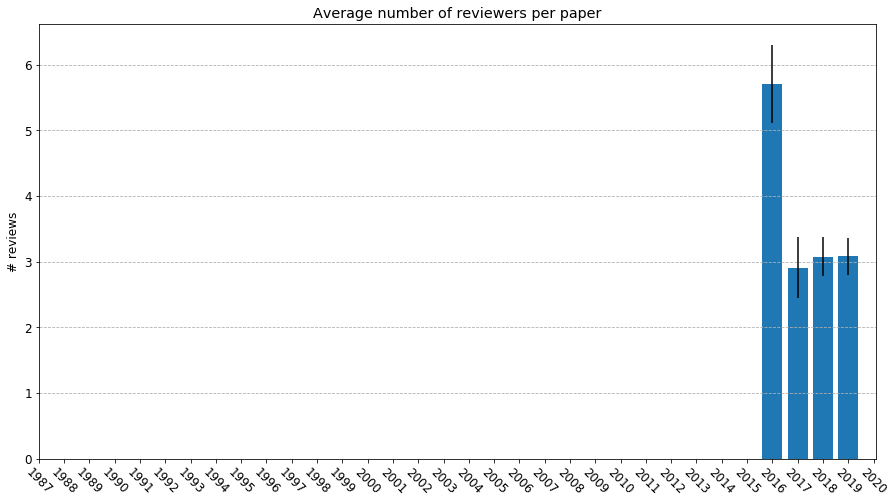

In [444]:
n_reviews = [np.mean([len(vv['reviews']) for vv in vals if vv['reviews'] is not None]) for vals in conf_data.values()]
n_reviews_std = [np.std([len(vv['reviews']) for vv in vals if vv['reviews'] is not None]) for vals in conf_data.values()]
plt.bar(np.arange(len(conf_data)), n_reviews, yerr=n_reviews_std)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average number of reviewers per paper')
plt.ylabel('# reviews')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
# plt.savefig('plots/fig__reviews_per_paper.png', dpi=300, bbox_inches='tight')
plt.show()

/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


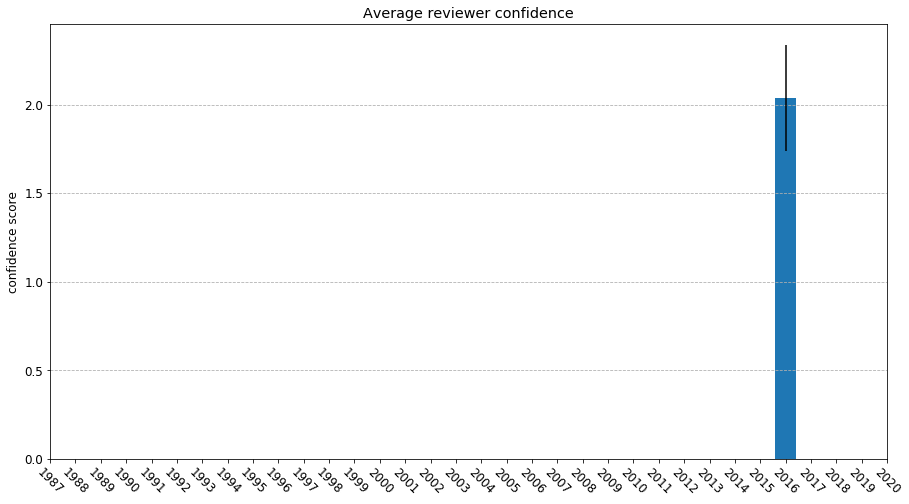

In [445]:
review_score = [np.mean([np.mean([rc['confidence'] for rc in vv['reviews'].values() if rc['confidence'] is not None]) for vv in vals if vv['reviews'] is not None]) for vals in conf_data.values()]
review_score_std = [np.std([np.mean([rc['confidence'] for rc in vv['reviews'].values() if rc['confidence'] is not None]) for vv in vals if vv['reviews'] is not None]) for vals in conf_data.values()]
plt.bar(np.arange(len(conf_data)), review_score, yerr=review_score_std)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average reviewer confidence')
plt.ylabel('confidence score')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
# plt.savefig('plots/fig__reviews_confidence.png', dpi=300, bbox_inches='tight')
plt.show()

/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


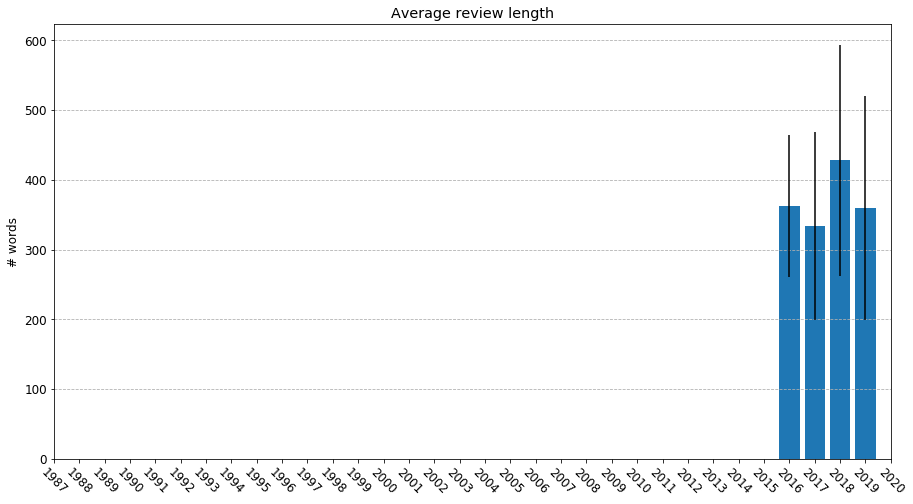

In [446]:
review_words = [np.mean([np.mean([len(rc['text'].split(' ')) for rc in vv['reviews'].values()]) for vv in vals if vv['reviews'] is not None]) for vals in conf_data.values()]
review_words_std = [np.std([np.mean([len(rc['text'].split(' ')) for rc in vv['reviews'].values()]) for vv in vals if vv['reviews'] is not None]) for vals in conf_data.values()]
plt.bar(np.arange(len(conf_data)), review_words, yerr=review_words_std)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average review length')
plt.ylabel('# words')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
# plt.savefig('plots/fig__reviews_length.png', dpi=300, bbox_inches='tight')
plt.show()